# Notatnik wzorowany na https://github.com/usuyama/pytorch-unet/blob/master/pytorch_unet.ipynb

In [1]:
!pip install torchinfo

In [2]:
import os
#set workdir
os.chdir("/content/drive/MyDrive/RiverSemanticSegmentation/")

In [3]:
#imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader
from dataloader import Dataset
from torchinfo import summary
import time
import copy
import pdb
from tqdm import tqdm


In [4]:
#training parameters in neptune format
PARAMS = {
    "input_size": 416,
    "output_size": 416,
    "model": "vgg_deconvnet",
    "learning_rate": 0.001,
    "batch_size": 8,
    'epochs': 1000,
    'patience': 10,
    "train_dataset_size": -1,
    "test_dataset_size": -1,
    "n_classes": 2,
    'image_preload': False
}

In [5]:
#neptune installation and initialization
!pip install neptune-client
import neptune
neptune.init(project_qualified_name='radek/pth1',
             api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vdWkubmVwdHVuZS5haSIsImFwaV91cmwiOiJodHRwczovL3VpLm5lcHR1bmUuYWkiLCJhcGlfa2V5IjoiYmY4YjQ3YjEtNmY5My00MDc2LWI4NzAtMWE5MmUwZjQ1NDE2In0=',
             )
neptune.create_experiment(params=PARAMS)


https://ui.neptune.ai/radek/pth1/e/PTH1-128


Experiment(PTH1-128)

In [6]:
#dataset configuration
dataset_dir = os.path.normpath("/content/drive/MyDrive/SemanticSegmentationV2/dataset/")
x_train_dir = os.path.join(dataset_dir,"x_train")
y_train_dir = os.path.join(dataset_dir,"y_train")
x_test_dir = os.path.join(dataset_dir,"x_test")
y_test_dir = os.path.join(dataset_dir,"y_test")

train_set = Dataset(x_train_dir, y_train_dir, input_size=PARAMS['input_size'], output_size=PARAMS['output_size'], n_classes=PARAMS["n_classes"], count=PARAMS["train_dataset_size"])
test_set = Dataset(x_test_dir, y_test_dir, input_size=PARAMS['input_size'], output_size=PARAMS['output_size'], n_classes=PARAMS["n_classes"], count=PARAMS["test_dataset_size"])

batch_size = PARAMS['batch_size']
dataloaders = {
    'train': DataLoader(train_set, batch_size=PARAMS['batch_size'], shuffle=True, num_workers=0),
    'val': DataLoader(test_set, batch_size=PARAMS['batch_size'], shuffle=True, num_workers=0)
}

In [7]:
# load images - useful if you want to save some time by preloading images (very time-consuming) when 
# the model is still not fuctional and cant run standard training.
if PARAMS['image_preload']:
  for phase in dataloaders:
    for inputs, labels in tqdm(dataloaders[phase]):
      pass


In [8]:
#model loading
if PARAMS['model'] == "simple":
  from models.simple import Simple
  model = Simple()
elif PARAMS['model'] == "vgg_unet":
  from models.vgg_unet import VggUnet
  model = VggUnet()
elif PARAMS['model'] == "vgg_unet_ks":
  from models.vgg_unet_ks import VggUnetKs
  model = VggUnetKs()
elif PARAMS['model'] == "unet":
  from models.unet import UNet
  model = UNet()
elif PARAMS['model'] == "vgg_deconvnet":
  from models.vgg16_deconvnet import VggDeconvNet
  model = VggDeconvNet()

In [9]:
#model structure preview
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
summary(model, input_size=(PARAMS['batch_size'], 3, PARAMS['input_size'], PARAMS['input_size']))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-1                       [8, 64, 416, 416]         1,792
|    └─ReLU: 2-2                         [8, 64, 416, 416]         --
|    └─Conv2d: 2-3                       [8, 64, 416, 416]         36,928
|    └─ReLU: 2-4                         [8, 64, 416, 416]         --
|    └─MaxPool2d: 2-5                    [8, 64, 208, 208]         --
|    └─Conv2d: 2-6                       [8, 128, 208, 208]        73,856
|    └─ReLU: 2-7                         [8, 128, 208, 208]        --
|    └─Conv2d: 2-8                       [8, 128, 208, 208]        147,584
|    └─ReLU: 2-9                         [8, 128, 208, 208]        --
|    └─MaxPool2d: 2-10                   [8, 128, 104, 104]        --
|    └─Conv2d: 2-11                      [8, 256, 104, 104]        295,168
|    └─ReLU: 2-12                        [8, 256, 104, 104]     

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1                          []                        --
|    └─Conv2d: 2-1                       [8, 64, 416, 416]         1,792
|    └─ReLU: 2-2                         [8, 64, 416, 416]         --
|    └─Conv2d: 2-3                       [8, 64, 416, 416]         36,928
|    └─ReLU: 2-4                         [8, 64, 416, 416]         --
|    └─MaxPool2d: 2-5                    [8, 64, 208, 208]         --
|    └─Conv2d: 2-6                       [8, 128, 208, 208]        73,856
|    └─ReLU: 2-7                         [8, 128, 208, 208]        --
|    └─Conv2d: 2-8                       [8, 128, 208, 208]        147,584
|    └─ReLU: 2-9                         [8, 128, 208, 208]        --
|    └─MaxPool2d: 2-10                   [8, 128, 104, 104]        --
|    └─Conv2d: 2-11                      [8, 256, 104, 104]        295,168
|    └─ReLU: 2-12                        [8, 256, 104, 104]     

In [10]:
from collections import defaultdict
import torch.nn.functional as F
SMOOTH = 1e-6
def iou_metric(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs[:,1,:,:]  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels[:,1,:,:]
    intersection = (outputs * labels).sum(2).sum(1)  # Will be zero if Truth=0 or Prediction=0
    union = (outputs + labels).sum(2).sum(1) - intersection  # Will be zzero if both are 0
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    return iou.mean()
    

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()    
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def calc_loss(pred, target, metrics, bce_weight=0.5):
    pred = torch.sigmoid(pred)
    bce = F.binary_cross_entropy(pred, target)
    pred = torch.round(pred)
    dice = dice_loss(pred, target)
    loss = bce# * bce_weight + dice * (1 - bce_weight)
    iou = iou_metric(pred, target)
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    metrics['iou'] += iou.data.cpu().numpy() * target.size(0)
    return loss

def print_metrics(metrics, epoch_samples, phase):   
    print(epoch_samples) 
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        neptune.log_metric(phase+"_"+k, metrics[k] / epoch_samples) #log
    print("{}: {}".format(phase, ", ".join(outputs)))    



In [11]:
#training loop
def train_model(model, dataloaders, optimizer, device, num_epochs=25, patience=-1):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_accuracy = 0
    no_improvement = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)
                    #print(model.encoder[0].weight.grad)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        #pdb.set_trace()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples
            epoch_accuracy = metrics['iou'] / epoch_samples

            # deep copy the model
            if phase == 'val':
              if epoch_accuracy > best_accuracy:
                no_improvement = 0
                print("Accuracy improvement achieved - saving best model.")
                best_accuracy = epoch_accuracy
                best_model_wts = copy.deepcopy(model.state_dict())
              else:
                no_improvement += 1
                print("No accuracy improvement since {}/{} epochs.".format(no_improvement,patience))
        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        if patience >= 0 and no_improvement > patience:
          break
    print('Best accuracy: {:4f}'.format(best_accuracy))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [12]:
#model training
optimizer_ft = optim.Adam(model.parameters(), lr=PARAMS['learning_rate'])
model = train_model(model, dataloaders, optimizer_ft, device, num_epochs=PARAMS['epochs'], patience=PARAMS['patience'])

  0%|          | 0/302 [00:00<?, ?it/s]

Epoch 0/999
----------
LR 0.001


100%|██████████| 302/302 [57:26<00:00, 11.41s/it]


2412


  0%|          | 0/72 [00:00<?, ?it/s]

train: bce: 0.638858, dice: 0.538181, loss: 0.638858, iou: 0.004017


100%|██████████| 72/72 [12:37<00:00, 10.52s/it]


570


  0%|          | 0/302 [00:00<?, ?it/s]

val: bce: 0.585736, dice: 0.521841, loss: 0.585736, iou: 0.005263
Accuracy improvement achieved - saving best model.
70m 6s
Epoch 1/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.543388, dice: 0.521511, loss: 0.543388, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.505859, dice: 0.521841, loss: 0.505859, iou: 0.005263
No accuracy improvement since 1/10 epochs.
2m 54s
Epoch 2/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.474342, dice: 0.521511, loss: 0.474342, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.447573, dice: 0.521841, loss: 0.447573, iou: 0.005263
No accuracy improvement since 2/10 epochs.
2m 54s
Epoch 3/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.424173, dice: 0.521511, loss: 0.424173, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.405406, dice: 0.521841, loss: 0.405406, iou: 0.005263
Accuracy improvement achieved - saving best model.
2m 54s
Epoch 4/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.387905, dice: 0.521511, loss: 0.387905, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.374961, dice: 0.521841, loss: 0.374961, iou: 0.005263
No accuracy improvement since 1/10 epochs.
2m 53s
Epoch 5/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.361830, dice: 0.521511, loss: 0.361830, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.353315, dice: 0.521841, loss: 0.353315, iou: 0.005263
Accuracy improvement achieved - saving best model.
2m 53s
Epoch 6/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.343204, dice: 0.521511, loss: 0.343204, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.337936, dice: 0.521841, loss: 0.337936, iou: 0.005263
No accuracy improvement since 1/10 epochs.
2m 54s
Epoch 7/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.330064, dice: 0.521511, loss: 0.330064, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.327189, dice: 0.521841, loss: 0.327189, iou: 0.005263
No accuracy improvement since 2/10 epochs.
2m 54s
Epoch 8/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.320918, dice: 0.521511, loss: 0.320918, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.319824, dice: 0.521841, loss: 0.319824, iou: 0.005263
No accuracy improvement since 3/10 epochs.
2m 53s
Epoch 9/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.314688, dice: 0.521511, loss: 0.314688, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.314930, dice: 0.521841, loss: 0.314930, iou: 0.005263
No accuracy improvement since 4/10 epochs.
2m 54s
Epoch 10/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.310544, dice: 0.521511, loss: 0.310544, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.311741, dice: 0.521841, loss: 0.311741, iou: 0.005263
Accuracy improvement achieved - saving best model.
2m 54s
Epoch 11/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.307856, dice: 0.521511, loss: 0.307856, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.309714, dice: 0.521841, loss: 0.309714, iou: 0.005263
No accuracy improvement since 1/10 epochs.
2m 53s
Epoch 12/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.306171, dice: 0.521511, loss: 0.306171, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.308521, dice: 0.521841, loss: 0.308521, iou: 0.005263
No accuracy improvement since 2/10 epochs.
2m 54s
Epoch 13/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.305191, dice: 0.521511, loss: 0.305191, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.307879, dice: 0.521841, loss: 0.307879, iou: 0.005263
No accuracy improvement since 3/10 epochs.
2m 54s
Epoch 14/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.304657, dice: 0.521511, loss: 0.304657, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.307549, dice: 0.521841, loss: 0.307549, iou: 0.005263
No accuracy improvement since 4/10 epochs.
2m 54s
Epoch 15/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.304377, dice: 0.521511, loss: 0.304377, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.307398, dice: 0.521841, loss: 0.307398, iou: 0.005263
No accuracy improvement since 5/10 epochs.
2m 53s
Epoch 16/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.304244, dice: 0.521511, loss: 0.304244, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.307333, dice: 0.521841, loss: 0.307333, iou: 0.005263
No accuracy improvement since 6/10 epochs.
2m 53s
Epoch 17/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.304183, dice: 0.521511, loss: 0.304183, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.307317, dice: 0.521841, loss: 0.307317, iou: 0.005263
No accuracy improvement since 7/10 epochs.
2m 53s
Epoch 18/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.304154, dice: 0.521511, loss: 0.304154, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.307316, dice: 0.521841, loss: 0.307316, iou: 0.005263
No accuracy improvement since 8/10 epochs.
2m 54s
Epoch 19/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.304150, dice: 0.521511, loss: 0.304150, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.307320, dice: 0.521841, loss: 0.307320, iou: 0.005263
Accuracy improvement achieved - saving best model.
2m 54s
Epoch 20/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.304144, dice: 0.521511, loss: 0.304144, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.307324, dice: 0.521841, loss: 0.307324, iou: 0.005263
No accuracy improvement since 1/10 epochs.
2m 54s
Epoch 21/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.304146, dice: 0.521511, loss: 0.304146, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.307326, dice: 0.521841, loss: 0.307326, iou: 0.005263
No accuracy improvement since 2/10 epochs.
2m 54s
Epoch 22/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.304142, dice: 0.521511, loss: 0.304142, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.307324, dice: 0.521841, loss: 0.307324, iou: 0.005263
No accuracy improvement since 3/10 epochs.
2m 54s
Epoch 23/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.304144, dice: 0.521511, loss: 0.304144, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.307321, dice: 0.521841, loss: 0.307321, iou: 0.005263
No accuracy improvement since 4/10 epochs.
2m 54s
Epoch 24/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.304143, dice: 0.521511, loss: 0.304143, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.307322, dice: 0.521841, loss: 0.307322, iou: 0.005263
No accuracy improvement since 5/10 epochs.
2m 54s
Epoch 25/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.304146, dice: 0.521511, loss: 0.304146, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.307325, dice: 0.521841, loss: 0.307325, iou: 0.005263
No accuracy improvement since 6/10 epochs.
2m 54s
Epoch 26/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.304149, dice: 0.521511, loss: 0.304149, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.307326, dice: 0.521841, loss: 0.307326, iou: 0.005263
No accuracy improvement since 7/10 epochs.
2m 54s
Epoch 27/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.304152, dice: 0.521511, loss: 0.304152, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.307326, dice: 0.521841, loss: 0.307326, iou: 0.005263
No accuracy improvement since 8/10 epochs.
2m 54s
Epoch 28/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.304149, dice: 0.521511, loss: 0.304149, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.307330, dice: 0.521841, loss: 0.307330, iou: 0.005263
No accuracy improvement since 9/10 epochs.
2m 54s
Epoch 29/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.304148, dice: 0.521511, loss: 0.304148, iou: 0.004561


  0%|          | 0/302 [00:00<?, ?it/s]

570
val: bce: 0.307328, dice: 0.521841, loss: 0.307328, iou: 0.005263
No accuracy improvement since 10/10 epochs.
2m 54s
Epoch 30/999
----------
LR 0.001


  0%|          | 0/72 [00:00<?, ?it/s]

2412
train: bce: 0.304149, dice: 0.521511, loss: 0.304149, iou: 0.004561


100%|██████████| 72/72 [00:26<00:00,  2.75it/s]

570
val: bce: 0.307326, dice: 0.521841, loss: 0.307326, iou: 0.005263
No accuracy improvement since 11/10 epochs.
2m 54s
Best accuracy: 0.005263


In [13]:
# save weights
torch.save(model.state_dict(),"state_dict.pth")

In [14]:
# load weights
model.load_state_dict(torch.load("state_dict.pth", map_location="cpu"))

<All keys matched successfully>

In [15]:
# denormalization function
from torchvision import transforms
inv_normalize = transforms.Normalize(
   mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
   std=[1/0.229, 1/0.224, 1/0.225]
)

def reverse_transform(inp):
    print(inp.shape)
    inp = inv_normalize(inp)
    inp = inp.numpy()
    inp = np.swapaxes(inp, 1, 3)
    inp = np.swapaxes(inp, 1, 2)
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp
def labels2mask(labels):
    return labels[:,1,:,:]

In [16]:
# helper function to plot input, ground truth and predict images in grid
import matplotlib.pyplot as plt
def plot_side_by_side(rgb,ground_truth,predict):
  assert rgb.shape[0] == ground_truth.shape[0] == predict.shape[0]
  batch_size = rgb.shape[0]
  fig, axs = plt.subplots(batch_size, 3, figsize=(30,50))
  for i in range(batch_size):
    axs[i, 0].imshow(rgb[i])
    axs[i, 1].imshow(ground_truth[i])
    axs[i, 2].imshow(predict[i])

tensor([[[[0.9088, 0.9088, 0.9088,  ..., 0.9088, 0.9088, 0.9088],
          [0.9088, 0.9088, 0.9088,  ..., 0.9088, 0.9088, 0.9088],
          [0.9088, 0.9088, 0.9088,  ..., 0.9088, 0.9088, 0.9088],
          ...,
          [0.9088, 0.9088, 0.9088,  ..., 0.9088, 0.9088, 0.9088],
          [0.9088, 0.9088, 0.9088,  ..., 0.9088, 0.9088, 0.9088],
          [0.9088, 0.9088, 0.9088,  ..., 0.9088, 0.9088, 0.9088]],

         [[0.0912, 0.0912, 0.0912,  ..., 0.0912, 0.0912, 0.0912],
          [0.0912, 0.0912, 0.0912,  ..., 0.0912, 0.0912, 0.0912],
          [0.0912, 0.0912, 0.0912,  ..., 0.0912, 0.0912, 0.0912],
          ...,
          [0.0912, 0.0912, 0.0912,  ..., 0.0912, 0.0912, 0.0912],
          [0.0912, 0.0912, 0.0912,  ..., 0.0912, 0.0912, 0.0912],
          [0.0912, 0.0912, 0.0912,  ..., 0.0912, 0.0912, 0.0912]]],


        [[[0.9088, 0.9088, 0.9088,  ..., 0.9088, 0.9088, 0.9088],
          [0.9088, 0.9088, 0.9088,  ..., 0.9088, 0.9088, 0.9088],
          [0.9088, 0.9088, 0.9088,  ...,

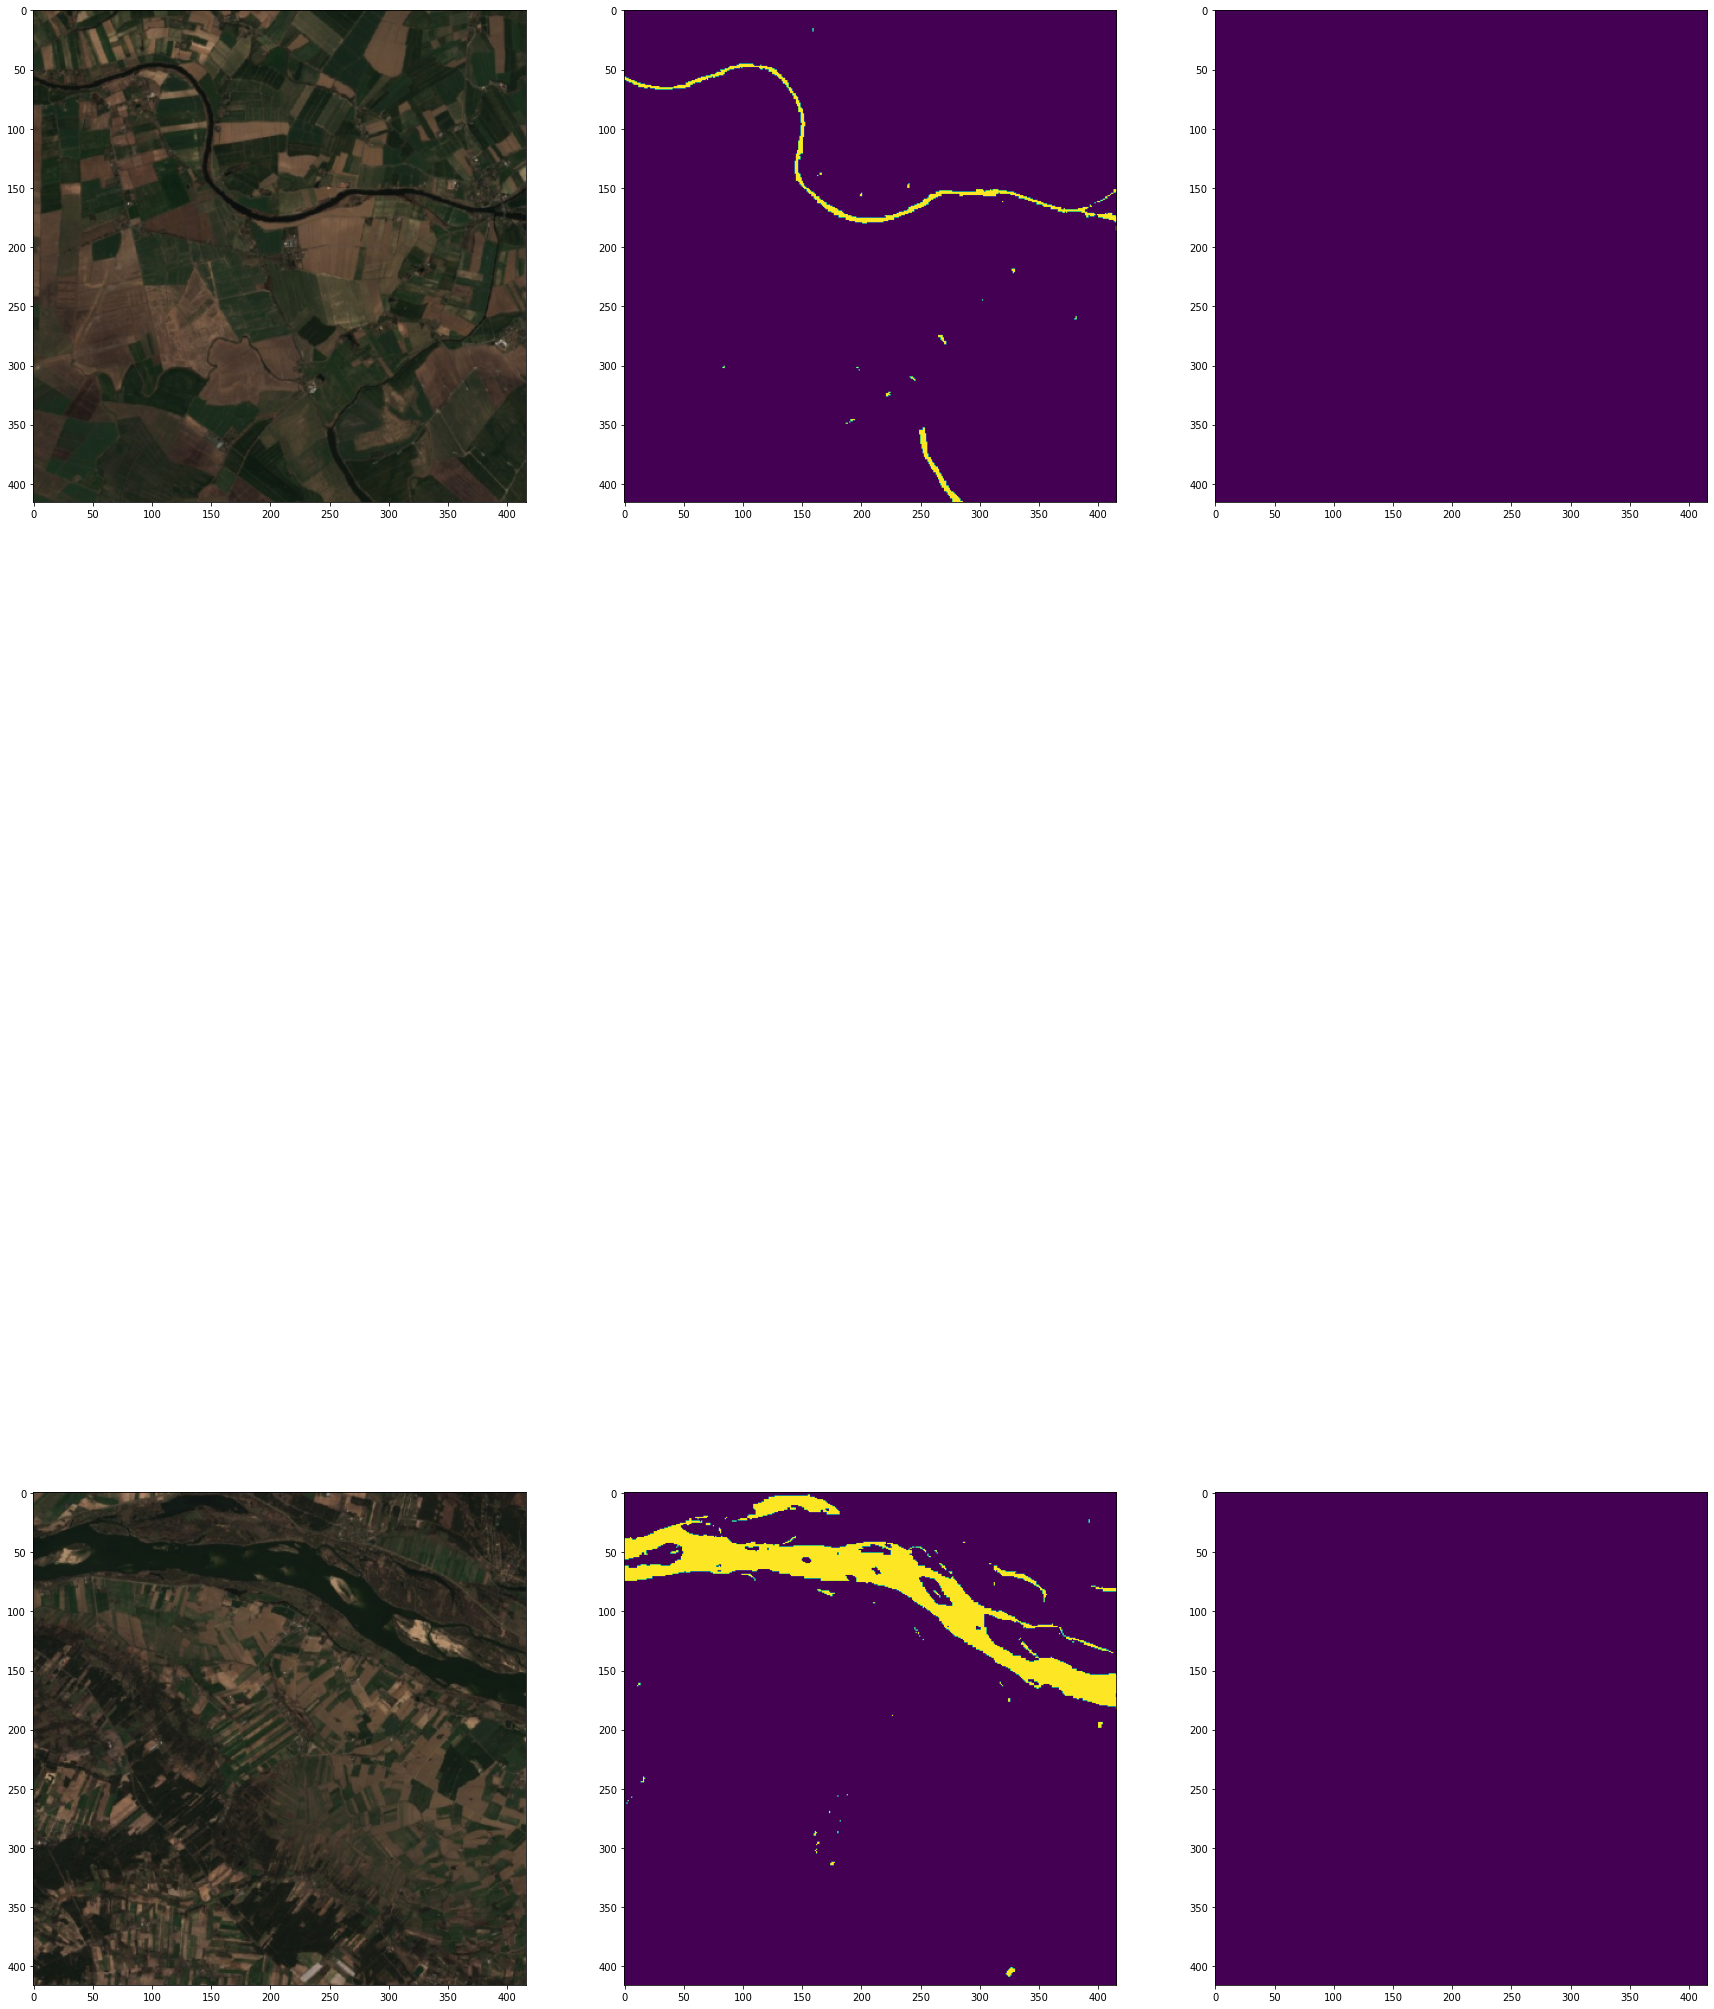

In [17]:
# visualize example segmentation
import math
model.eval()   # Set model to evaluate mode
test_dataset = Dataset(x_test_dir, y_test_dir, input_size=PARAMS['input_size'], output_size=PARAMS['output_size'], n_classes=PARAMS['n_classes'])
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=True, num_workers=0)
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

labels = labels.data.cpu().numpy()
pred = model(inputs)

pred = torch.sigmoid(pred)

print(pred)
pred = torch.round(pred)
print(pred.size())

pred = pred.data.cpu().numpy()
inputs = inputs.data.cpu()

# dataloader return normalized input image, so we have to denormalize before viewing
input_images = reverse_transform(inputs)
# target and predict mask are single channel, so squeeze
target_masks = labels2mask(labels)

pred = labels2mask(pred)

# use helper function to plot
plot_side_by_side(input_images, target_masks, pred)

In [18]:
#evaluate model
test_dataset = Dataset(x_test_dir, y_test_dir, input_size=PARAMS['input_size'], output_size=PARAMS['output_size'], n_classes=PARAMS['n_classes'])
test_loader = DataLoader(test_dataset, batch_size=PARAMS["batch_size"], shuffle=True, num_workers=0)
intersection=0
union=0
for inputs, labels in tqdm(test_loader):
  inputs = inputs.to(device)
  labels = labels.to(device)
  labels = labels.data.cpu().numpy()
  pred = model(inputs)
  pred = torch.sigmoid(pred)
  pred = torch.round(pred)
  pred = pred.data.cpu().numpy()
  target = labels[:,1,:,:]
  predict = pred[:,1,:,:]
  temp = (target * predict).sum()
  intersection+=temp
  union+=((target + predict).sum() - temp)
iou = intersection/union
print("IoU: {}".format(iou))
neptune.log_metric("total_iou",iou)

100%|██████████| 72/72 [00:36<00:00,  1.96it/s]


IoU: 0.0


In [19]:
# update neptune status
neptune.stop()